In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

# Upload, resize and visualize images

In [2]:
def add_status(train):
    
    # It has been done this wah in order to avoid unnecessary warnings
    train['status'] = 0
    train.loc[train.healthy == 1, 'status'] = 'healthy'
    train.loc[train.multiple_diseases == 1, 'status'] = 'multiple_diseases'
    train.loc[train.rust == 1, 'status'] = 'rust'
    train.loc[train.scab == 1, 'status'] = 'scab'
    
    return train


In [3]:
def load_images(train):
    
    # This function loads the images, resizes them and puts them into an array
    
    img_size = 224
    train_image = []
    for name in train['image_id']:
        path = directory + 'images/' + name + '.jpg'
        img = cv2.imread(path)
        image = cv2.resize(img, (img_size, img_size))
        train_image.append(image)
    train_image_array = np.array(train_image)
    
    return train_image_array

In [4]:
def show_images(images, labels = None):
    
    # This function takes the images and the labels if they exist and
    # plots them
    
    fig, ax1= plt.subplots(1, 4, figsize = (10,10))
    for i in range(4):
        ax1[i].set_axis_off()
        ax1[i].imshow(images[i])
        if labels is not None:
            ax1[i].title.set_text(labels[i])
    

In [5]:
directory = 'C:/Users/julen/OneDrive/Escritorio/IA/CS577-Deep-Learning/Project/'
sample_submission = pd.read_csv(directory + 'sample_submission.csv')
df_test = pd.read_csv(directory + 'test.csv')
df_train = pd.read_csv(directory + 'train.csv')

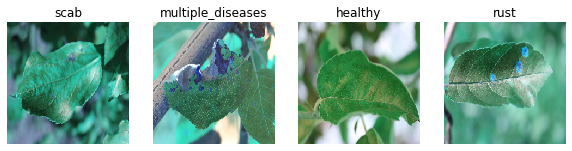

In [7]:
df_train = add_status(df_train)
train_img = load_images(df_train)
show_images(train_img, df_train['status'])

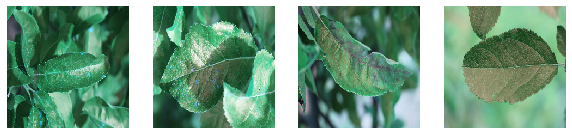

In [9]:
test_img = load_images(df_test)
show_images(test_img)

# Augment images and save them

In [22]:
def plot_flip():
    
    img = train_img[0]

    plt.subplot(131)
    plt.title('original image')
    plt.axis('off')
    plt.imshow(img)

    hflipped = np.fliplr(img)
    plt.subplot(132)
    plt.title('Horizontally flipped')
    plt.axis('off')
    plt.imshow(hflipped)

    vflipped = np.flipud(img)
    plt.subplot(133)
    plt.title('Horizontally flipped')
    plt.axis('off')
    plt.imshow(vflipped)


In [23]:
def plot_rotation():

    from skimage.transform import rotate
    
    img = train_img[0]
    
    r_image1 = rotate(img, angle = 45)
    r_image2 = rotate(img, angle = -45)

    plt.subplot(131)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img)


    plt.subplot(132)
    plt.title('45 degree rotated image')
    plt.axis('off')
    plt.imshow(r_image1)


    plt.subplot(133)
    plt.title('-45 degree rotated image')
    plt.axis('off')
    plt.imshow(r_image2)

In [24]:
def plot_noise():
    
    from skimage.util import random_noise
    img = train_img[0]

    noisy_image = random_noise(img, mode = 'gaussian')

    plt.subplot(121)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(122)
    plt.title('Noisy Image')
    plt.axis('off')
    plt.imshow(noisy_image)

In [25]:
def plot_blurred():
    
    img = train_img[0]
    
    blur_image = cv2.GaussianBlur(img, (9,9), 0)

    plt.subplot(121)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img)


    plt.subplot(122)
    plt.title('Blurred Image')
    plt.axis('off')
    plt.imshow(blur_image)

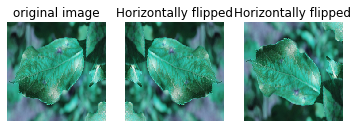

In [26]:
plot_flip()

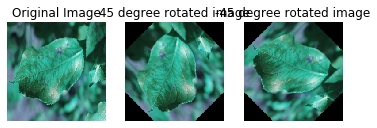

In [27]:
plot_rotation()

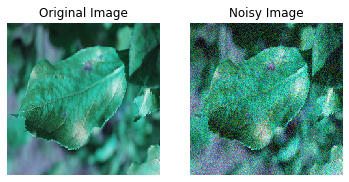

In [28]:
plot_noise()

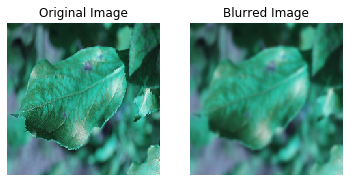

In [29]:
plot_blurred()

In [30]:
from skimage.transform import rotate
from numpy.random import randint
from skimage import img_as_float64, img_as_ubyte
from skimage.util import random_noise

def anticlockwise_rotation(image):
    angle = randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle = randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image): # This one? Don't know if good or bad for FGVC
    return random_noise(image)

def blur_image(image): # don't use this one, not good for FGVC
    return cv2.GaussianBlur(img, (9,9), 0)

transformations = {'rotate_anticlockwise' : anticlockwise_rotation,
                   'rotate_clockwise' : clockwise_rotation,
                   'horizontal_flip' : h_flip,
                   'vertical_flip' : v_flip}
                   # 'adding_noise' : add_noise}
                   #'blurring image' : blur_image}


In [31]:
augmented_path = directory + 'images_resized_augmented/' 
images_augmented = []
counter = 0
for i in range(0, len(train_img)):
    transformation_methods = list(transformations)
    
    for method in transformation_methods:
        image_new = transformations[method](train_img[i])
        images_augmented.append(image_new)
        img_name = 'Train_' + method + '_' + str(i) + '.jpg'
        transformed_image = img_as_ubyte(image_new)
        cv2.imwrite(augmented_path + img_name, transformed_image)
        
#     if i % 100 == 0:   
#         print('Process done with', i, 'images')

C:\Programs_julen\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [32]:
for i in range(0, len(train_img)):
    img_name = 'Train_' + str(i) + '.jpg'
    transformed_image = img_as_ubyte(train_img[i])
    cv2.imwrite(augmented_path + img_name, transformed_image)
    

In [33]:
# Augmente df_train (y vector)

df_train_add = df_train.copy()
df_train_new = df_train.copy()

for i in range(0, len(transformation_methods)):

    assert(len(df_train_new) == 1821 * (i+1))
    df_train_add['image_id'] = 'Train_' + transformation_methods[i] + df_train['image_id'].str.slice(start = 5)
    df_train_new = df_train_new.append(df_train_add)
    assert(len(df_train_new) == 1821 * (i+2))
    
df_train_new.to_csv(directory + 'augmented.csv', )



# Load images stored

In [34]:
def load_images_augmented():
    
    # This function loads the augmented images and the augmented csv file
    directory = 'C:/Users/julen/OneDrive/Escritorio/IA/CS577-Deep-Learning/Project/'
    df_train = pd.read_csv(directory + 'augmented.csv')
    
    train_image = []
    for name in df_train['image_id']:
        path = directory + 'images_resized_augmented/' + name + '.jpg'
        img = cv2.imread(path)
        train_image.append(img)
    train_image_array = np.array(train_image)
    
    return  train_image_array, df_train

In [35]:
x_train, df_train = load_images_augmented()

In [36]:
x_train.shape

(9105, 224, 224, 3)

In [37]:
df_train.shape

(9105, 7)

# Split training set into train and validation

# Build Convolutional Neural Network